In [0]:
# import libraries
import os
import zipfile
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# train datasets
!wget --no-check-certificate -O ./sample_data/rps-train.zip https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip

with zipfile.ZipFile('./sample_data/rps-train.zip', 'r') as zip_ref:
  zip_ref.extractall('./sample_data')

--2020-04-21 08:24:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 2a00:1450:400c:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘./sample_data/rps-train.zip’

./sample_data/rps-t 100%[===================>] 191.38M   205MB/s    in 0.9s    

2020-04-21 08:24:50 (205 MB/s) - ‘./sample_data/rps-train.zip’ saved [200682221/200682221]



In [3]:
# test datasets
!wget  --no-check-certificate -O ./sample_data/rps-test.zip https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip

with zipfile.ZipFile('./sample_data/rps-test.zip', 'r') as zip_ref:
  zip_ref.extractall('./sample_data')

--2020-04-21 08:24:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 2a00:1450:400c:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘./sample_data/rps-test.zip’

./sample_data/rps-t 100%[===================>]  28.15M   141MB/s    in 0.2s    

2020-04-21 08:24:54 (141 MB/s) - ‘./sample_data/rps-test.zip’ saved [29516758/29516758]



Number of train data: 2520
Number of test data: 372


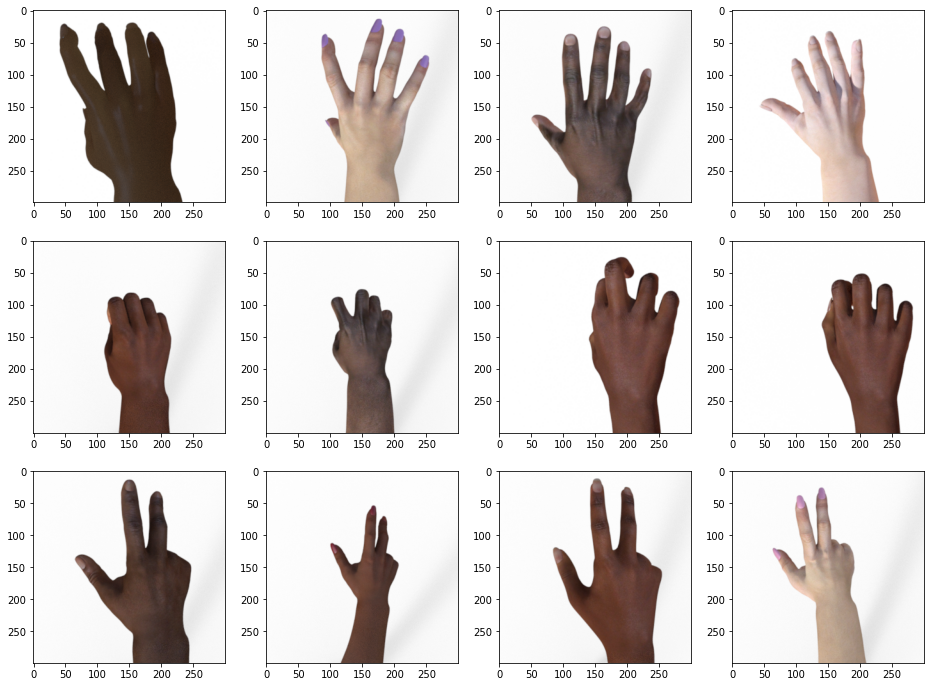

In [4]:
# === data info ===

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# datapath for train datasets
train_paper = os.path.join('./sample_data/rps/paper')
train_rock = os.path.join('./sample_data/rps/rock')
train_scissors = os.path.join('./sample_data/rps/scissors')

# datapath for test datasets
test_paper = os.path.join('./sample_data/rps-test-set/paper')
test_rock = os.path.join('./sample_data/rps-test-set/rock')
test_scissors = os.path.join('./sample_data/rps-test-set/scissors')

# number of data
train_len = len(os.listdir(train_paper)) + len(os.listdir(train_rock)) + len(os.listdir(train_scissors))
test_len = len(os.listdir(test_paper)) + len(os.listdir(test_rock)) + len(os.listdir(test_scissors))
print(f'Number of train data: {train_len}')
print(f'Number of test data: {test_len}')

# visualize the image data
paper_path = [os.path.join(train_paper, fname) for fname in os.listdir(train_paper)[:4]]
rock_path = [os.path.join(train_rock, fname) for fname in os.listdir(train_rock)[:4]]
scissors_path = [os.path.join(train_scissors, fname) for fname in os.listdir(train_scissors)[:4]]

fig = plt.figure(figsize=(16, 12))
for i, img_path in enumerate(paper_path + rock_path + scissors_path):
  img = mpimg.imread(img_path)
  fig.add_subplot(3, 4, i+1).imshow(img)
plt.show()                   

In [5]:
# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_batch_size = 256
train_generator = train_datagen.flow_from_directory(
    './sample_data/rps',
    target_size=(300, 300),
    batch_size=train_batch_size,
    class_mode='categorical'
)

test_batch_size = 32
test_generator = test_datagen.flow_from_directory(
    './sample_data/rps-test-set',
    target_size=(300, 300),
    batch_size=test_batch_size,
    class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [6]:
# model structure
model = keras.models.Sequential([
  # first layer
  keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
  keras.layers.MaxPooling2D(2, 2),
  # second layer
  keras.layers.Conv2D(32, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D(2, 2),
  # third layer
  keras.layers.Conv2D(64, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D(2, 2),
  # fourth layer
  keras.layers.Conv2D(64, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D(2, 2),
  # fifth layer
  keras.layers.Conv2D(32, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D(2, 2),
  # flatten the tensor
  keras.layers.Flatten(),
  # 512 neuron hidden layer
  keras.layers.Dense(512, activation='relu'),
  # output layer: paper, rock, scissors
  keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [0]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
# define Callback class
acc_goal = 0.99
class Callback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('acc') > acc_goal:
      print(f'\nReached {acc_goal} accuracy so cancelling training')
      self.model.stop_training = True

callbacks = Callback()

In [9]:
# training (fitting)
steps = (train_len-1) // train_batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=steps,
    epochs=5,
    verbose=1,
    callbacks=[callbacks]
)
print(f"\nAccuracy after training: {history.history['acc'][-1]}")

Epoch 1/5
10/10 [==============================] - 14s 1s/step - loss: 1.0287 - acc: 0.5044
Epoch 2/5
10/10 [==============================] - 12s 1s/step - loss: 0.6089 - acc: 0.7349
Epoch 3/5
10/10 [==============================] - 12s 1s/step - loss: 0.2135 - acc: 0.9417
Epoch 4/5
10/10 [==============================] - 12s 1s/step - loss: 0.0600 - acc: 0.9853
Epoch 5/5
10/10 [==============================] - ETA: 0s - loss: 0.0169 - acc: 0.9960
Reached 0.99 accuracy so cancelling training
10/10 [==============================] - 12s 1s/step - loss: 0.0169 - acc: 0.9960

Accuracy after training: 0.9960317611694336


In [10]:
# evaluation
steps = (test_len-1) // test_batch_size + 1
test_loss, acc_loss = model.evaluate(test_generator, steps=steps)

12/12 [==============================] - 2s 145ms/step - loss: 0.4890 - acc: 0.8280


In [12]:
# running the model
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = './' + fn
  img = image.load_img(path, target_size=(300, 300))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)

  classes = model.predict(img, batch_size=1)
  if classes[0][0] == 1:
    print(fn + ' is a paper')
  elif classes[0][1] == 1:
    print(fn + ' is a rock')
  else:
    print(fn + ' is a scissors')



Saving rock_ex.png to rock_ex.png
rock_ex.png is a rock
